#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import numpy as np
from keras.callbacks import EarlyStopping
import os
import statistics
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.models import load_model

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
data_train = pd.read_csv(path + 'data01_train.csv')

In [6]:
data_test = pd.read_csv(path + 'data01_test.csv')

In [7]:
features = pd.read_csv(path + 'features.csv')

In [8]:
data_train = data_train.drop(columns=['subject'])
data_test = data_test.drop(columns=['subject'])

In [9]:
data = data_train

#### 2) 기본 정보 조회

In [10]:
data_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [11]:
data.shape

(5881, 562)

In [12]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [13]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [117]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, [target]]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [106]:
scaler = MinMaxScaler()

df = scaler.fit_transform(x)

x = pd.DataFrame(df, columns=x.columns)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [118]:
# int_Encoder = LabelEncoder()
# y = int_Encoder.fit_transform(y)
activity_map = {
    'SITTING': 0,
    'STANDING': 1,
    'LAYING': 2,
    'WALKING': 3,
    'WALKING_UPSTAIRS': 4,
    'WALKING_DOWNSTAIRS': 5
    }

y['Activity'] = y['Activity'].map(activity_map)
y.head()

,Activity
0,1
1,2
2,1
3,3
4,5


In [20]:
y_labels = int_Encoder.classes_
y_labels

array([0, 1, 2, 3, 4, 5])

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [119]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=1004)

### 함수 선언

In [25]:
def dl_history_plot_2(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='train_err', marker='.')
    plt.plot(history.history['val_loss'], label='val_err', marker='.')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [81]:
def loop_fun(file_name, model, lr, epoch, iter, x_train, x_val, y_train, y_val):
  '''
  input
  - file_name : 원하는 파일 이름
  - model : 모델 객체 - 반복할 기본 모델
  - lr : learning_rate 비율
  - epoch : epochs 수
  - iter : int - 모델 학습을 반복할 횟수
  - x_train : 훈련 데이터의 feature
  - x_val : 검증 데이터의 feature
  - y_train : 훈련 데이터의 target
  - y_val : 검증 데이터의 target

  output
  - 각 반복의 모델 학습 과정, 혼동 행렬, 분류 보고서, 정확도 정보가 출력됩니다.
  - 최종적으로 가장 성능이 좋은 모델은 저장되며, 평균 정확도와 최고 정확도를 출력합니다.

  Description
  - 이 함수는 지정된 횟수(iter)만큼 모델 학습을 반복하며, 각 반복에서 EarlyStopping을 통해 훈련을 자동으로 중지합니다.
  - 반복마다 새로운 모델을 복사(clone_model)하고, 성능(정확도)을 측정한 후, 가장 성능이 좋은 모델을 저장합니다.
  - 최종적으로 반복 중 최고 성능을 기록한 모델과 관련된 정보를 출력합니다.
  '''

  # 최상의 정확도를 기록할 변수 초기화
  best_accuracy = -1
  best_model = None
  acc_list = []

  # 지정된 횟수(iter)만큼 반복하여 모델 학습
  for i in range(1, iter+1):
    clear_session()
    model_iter = clone_model(model)
    model_iter.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

    # EarlyStopping 설정 ------------
    min_de = 0.01
    pat = 10

    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)
    # --------------------------------

    # 모델 학습: 검증 데이터 비율은 20%로 설정
    history = model_iter.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=0, callbacks = [es])

    # 검증 데이터에 대해 예측 수행
    dl_history_plot_2(history)

    pred = model_iter.predict(x_val)
    pred_result = pred.argmax(axis=1)
    confusion = confusion_matrix(y_val, pred_result)
    report = classification_report(y_val, pred_result)
    accuracy = accuracy_score(y_val, pred_result)
    acc_list.append(accuracy)
    print(f"{i}번째 모델")
    print(f"정확도: {accuracy}")
    print(f"혼돈 행렬\n {confusion}")
    print(f"분류 보고서\n {report}")
    print("- * " * 30)

    # 현재 모델이 가장 성능이 좋다면, 해당 모델과 성능 기록을 저장
    if accuracy > best_accuracy:
      best_report = report
      best_confusion = confusion
      best_accuracy = accuracy
      best_model = model_iter

      file_name = f"{file_name}.keras"

      full_save_path = os.path.join(path, file_name)

      best_model.save(full_save_path)

  # 반복 학습 후 전체 평균 정확도 출력
  average_accuracy = statistics.mean(acc_list)
  print("- * " * 30)
  print(f"평균 정확도\n {average_accuracy}")
  print(f"최고 정확도\n {best_accuracy}")
  print(f"혼돈 행렬\n {best_confusion}")
  print(f"최고 분류 보고서\n {best_report}")

In [75]:
def prep_data_fa(x, y, topn=None, path='/content/drive/MyDrive/project3/'):
  '''
  input:
  - x
  - y
  - topn: (default: None, else int) Random Forest에서의 feature importances가 높은 상위 n개 feature만 사용

  output:
  - x_tr_acc: x_train에서 가속계 관련 column만 추출한 데이터
  - x_tr_gyro: x_train에서 Gyroscope 관련 column만 추출한 데이터
  - x_tr_angle: x_train에서 angle 관련 column만 추출한 데이터
  - x_val_acc: x_val에서 가속계 관련 column만 추출한 데이터
  - x_val_gyro: x_val에서 Gyroscope 관련 column만 추출한 데이터
  - x_val_angle: x_val에서 angle 관련 column만 추출한 데이터
  - y_train
  - y_val
  '''

  feats_csv = pd.read_csv(path + 'features.csv')

  # Feature name 추출
  sensor_acc = list(set([feat for feat in feats_csv['sensor'] if 'Acc' in feat]))
  sensor_gyro = list(set([feat for feat in feats_csv['sensor'] if 'Gyro' in feat]))
  feats_acc = list(feats_csv.loc[feats_csv['sensor'].isin(sensor_acc)]['feature_name'])
  feats_gyro = list(feats_csv.loc[feats_csv['sensor'].isin(sensor_gyro)]['feature_name'])
  feats_angle = list(feats_csv.loc[feats_csv['sensor'] == 'angle']['feature_name'])

  if topn is None:
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=1004)

  else:
    if not isinstance(topn, int): raise TypeError("topn must be integer value or None")
    data_import_att = pd.read_csv(path + 'import_att.csv')
    topn_features = data_import_att['feature_name'].head(topn)
    x_topn = x.loc[:, topn_features]
    x_train, x_val, y_train, y_val = train_test_split(x_topn, y, test_size=.2, random_state=1004)

    # features top n개 추려내기
    feats_acc = [feat for feat in feats_acc if feat in list(topn_features)]
    feats_gyro = [feat for feat in feats_gyro if feat in list(topn_features)]
    feats_angle = [feat for feat in feats_angle if feat in list(topn_features)]

  # 데이터 분할
  x_tr_acc = x_train.loc[:, feats_acc].reset_index(drop=True)
  x_tr_gyro = x_train.loc[:, feats_gyro].reset_index(drop=True)
  x_tr_angle = x_train.loc[:, feats_angle].reset_index(drop=True)
  x_val_acc = x_val.loc[:, feats_acc].reset_index(drop=True)
  x_val_gyro = x_val.loc[:, feats_gyro].reset_index(drop=True)
  x_val_angle = x_val.loc[:, feats_angle].reset_index(drop=True)

  return x_tr_acc, x_tr_gyro, x_tr_angle, x_val_acc, x_val_gyro, x_val_angle, y_train, y_val

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [31]:
nfeatures = x_train.shape[1]
nfeatures

561

In [35]:
# 기본 모델 설계

model_step1 = Sequential( [Input(shape = (nfeatures,)),
                     Dense( 6, activation = 'softmax')] )

model_step1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

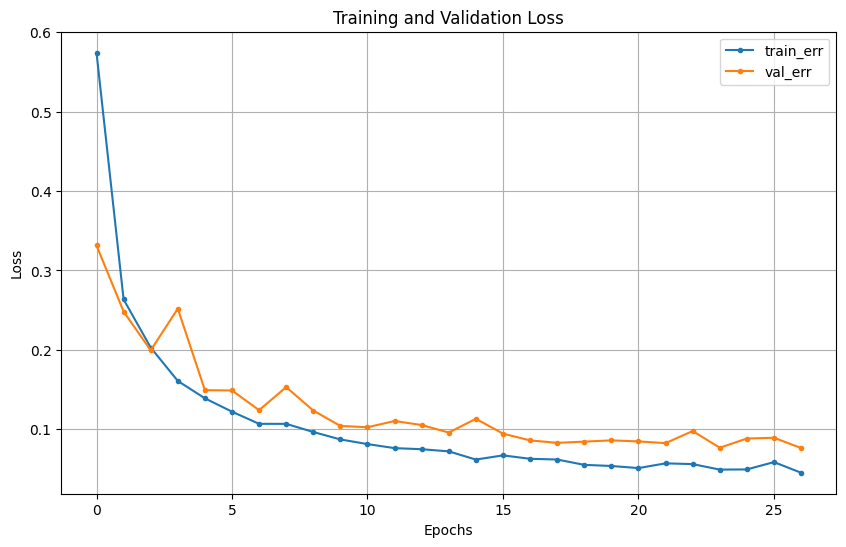

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1번째 모델
정확도: 0.9796091758708582
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 199  10   0   0   0]
 [  0   7 211   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   3   2 181]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.97      0.95      0.96       209
           2       0.95      0.97      0.96       218
           3       0.98      0.99      0.99       189
           4       0.98      1.00      0.99       150
           5       0.99      0.97      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


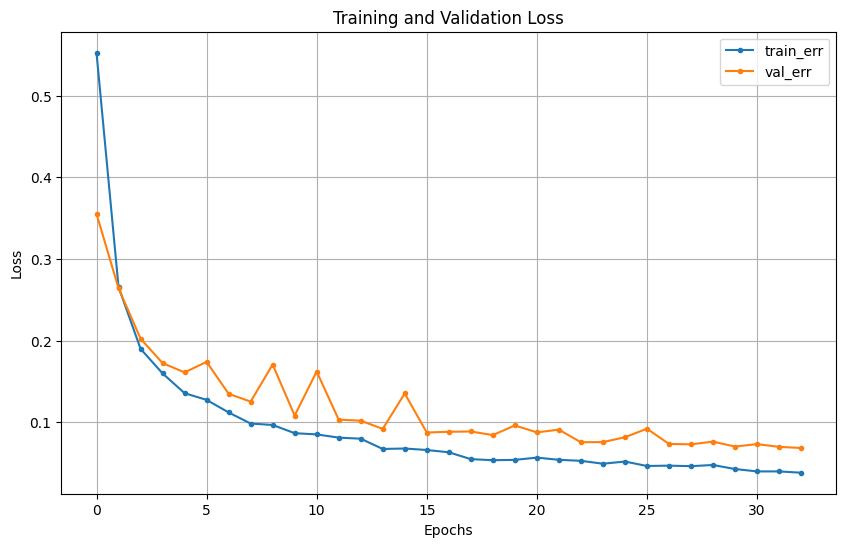

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2번째 모델
정확도: 0.9787595581988106
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 205   4   0   0   0]
 [  0  14 204   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 149   1]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.94      0.98      0.96       209
           2       0.98      0.94      0.96       218
           3       0.99      0.99      0.99       189
           4       0.98      0.99      0.99       150
           5       0.99      0.98      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


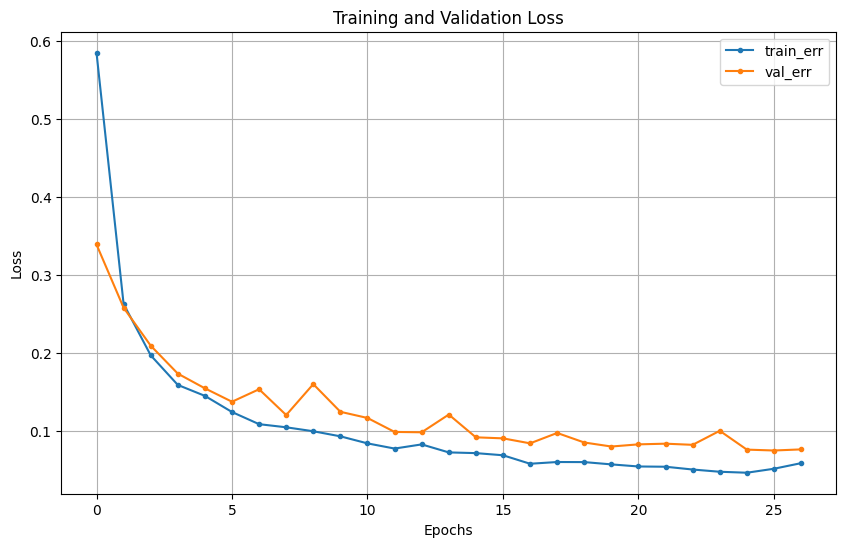

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3번째 모델
정확도: 0.9796091758708582
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 200   9   0   0   0]
 [  0   8 210   0   0   0]
 [  0   0   0 186   2   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.96      0.96      0.96       209
           2       0.96      0.96      0.96       218
           3       0.99      0.98      0.99       189
           4       0.97      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


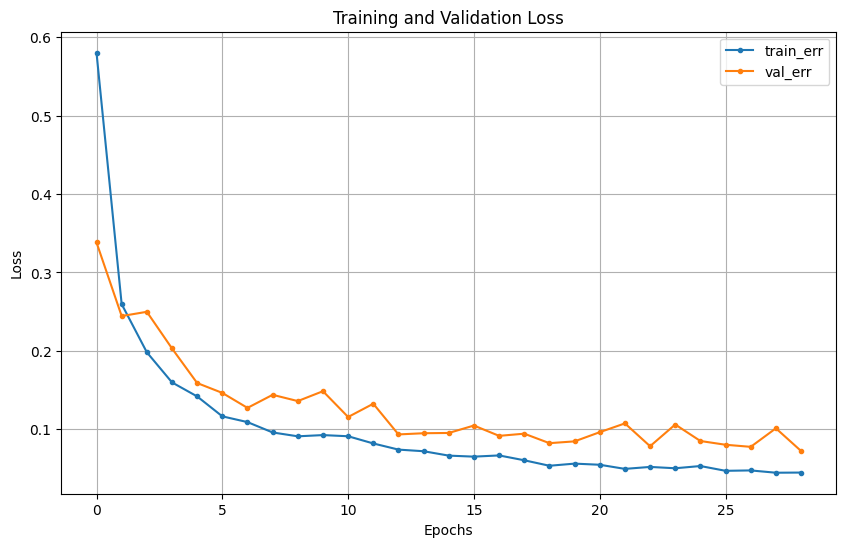

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4번째 모델
정확도: 0.9804587935429057
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 200   9   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 186   2   1]
 [  0   0   0   0 149   1]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.97      0.96      0.96       209
           2       0.96      0.97      0.97       218
           3       0.99      0.98      0.99       189
           4       0.97      0.99      0.98       150
           5       0.99      0.98      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


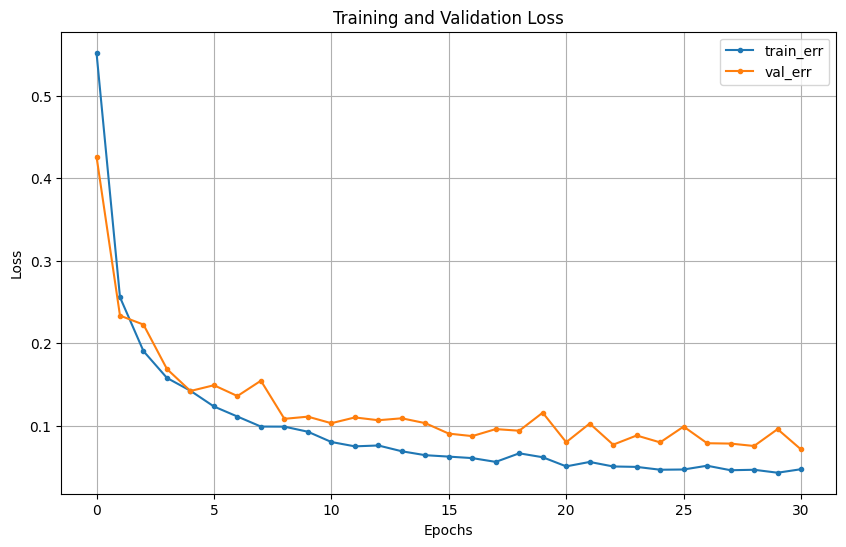

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5번째 모델
정확도: 0.9762107051826678
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 205   4   0   0   0]
 [  0  15 203   0   0   0]
 [  0   0   0 185   2   2]
 [  0   0   0   0 148   2]
 [  0   0   0   1   2 183]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.93      0.98      0.96       209
           2       0.98      0.93      0.96       218
           3       0.99      0.98      0.99       189
           4       0.97      0.99      0.98       150
           5       0.98      0.98      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [42]:
model_name = "basic_model"
lr = 0.01
epochs = 100
loop_fun(model_name, model_step1, lr, epochs, 5, x_train, x_val, y_train, y_val)

### (2) 모델2

In [45]:
# 메모리 정리
clear_session()

# Sequential
model2 = Sequential( [Input(shape = (nfeatures,)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense( 6, activation = 'softmax')] )

# 모델요약
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,934 (1.77 MB)

 Trainable params: 462,934 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

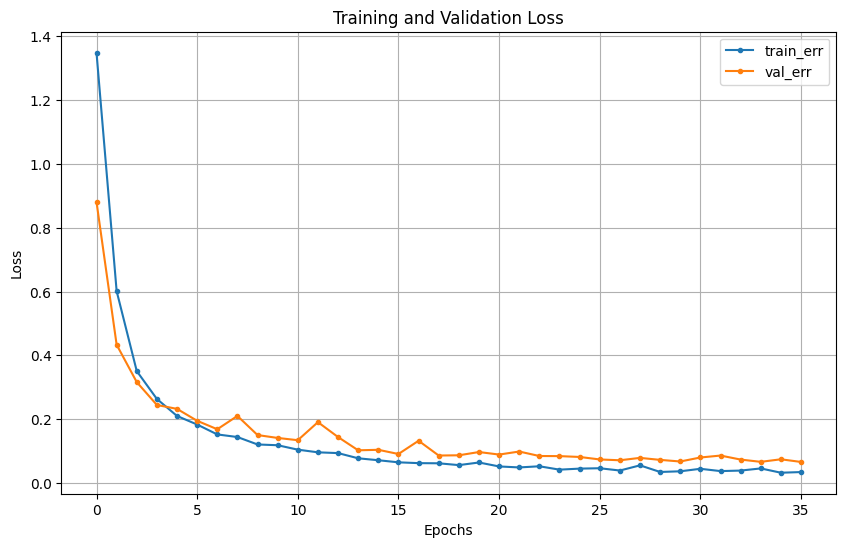

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1번째 모델
정확도: 0.9847068819031436
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 199  10   0   0   0]
 [  0   3 215   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.99      0.95      0.97       209
           2       0.96      0.99      0.97       218
           3       0.99      0.99      0.99       189
           4       0.99      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


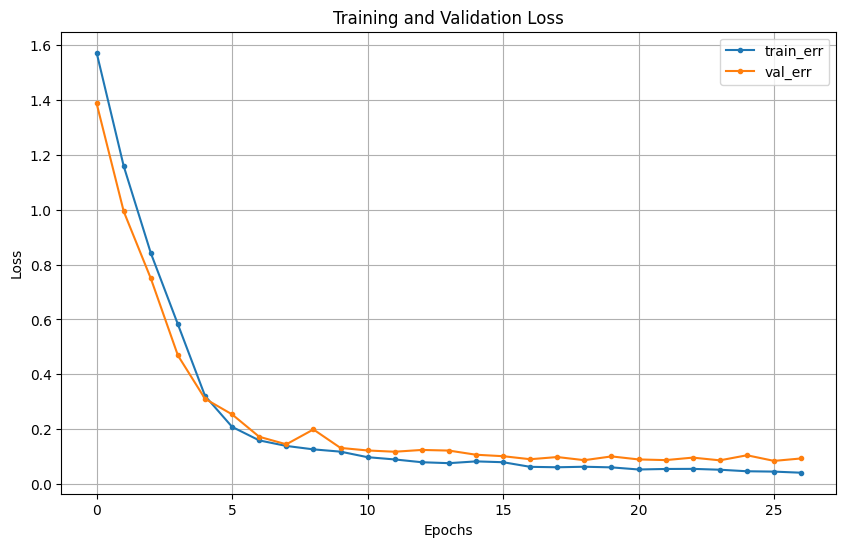

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2번째 모델
정확도: 0.9770603228547153
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 192  17   0   0   0]
 [  0   4 214   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.98      0.92      0.95       209
           2       0.93      0.98      0.95       218
           3       0.99      0.99      0.99       189
           4       0.98      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


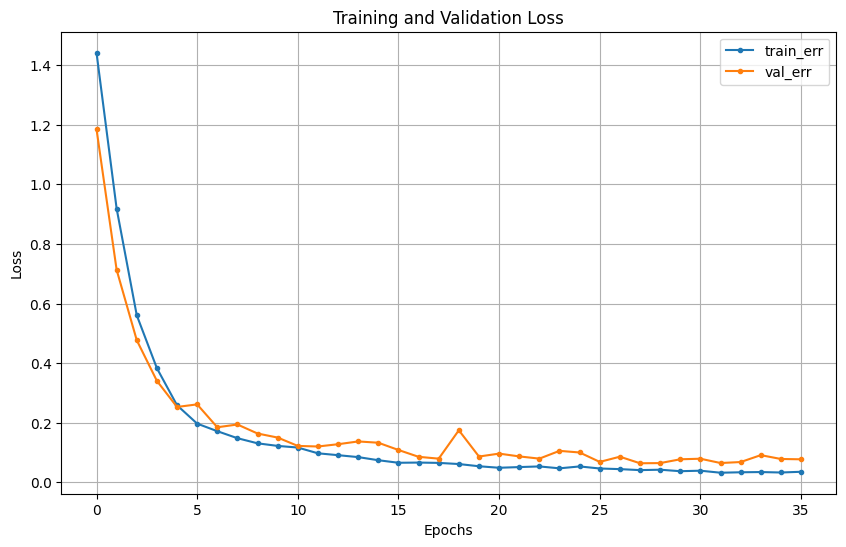

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3번째 모델
정확도: 0.9779099405267629
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 194  15   0   0   0]
 [  0   3 215   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 147   3]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.98      0.93      0.96       209
           2       0.93      0.99      0.96       218
           3       0.99      0.99      0.99       189
           4       0.99      0.98      0.98       150
           5       0.98      0.98      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


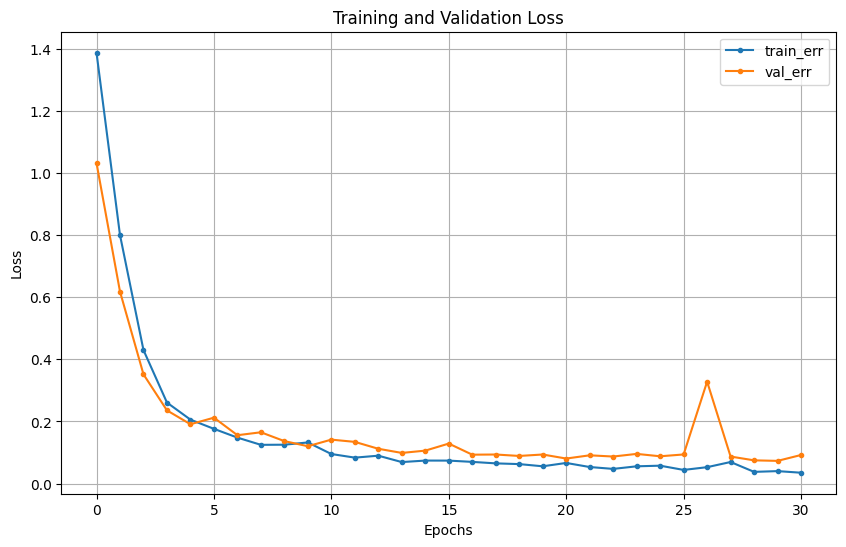

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4번째 모델
정확도: 0.9779099405267629
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 191  18   0   0   0]
 [  0   3 215   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.98      0.91      0.95       209
           2       0.92      0.99      0.95       218
           3       0.99      0.99      0.99       189
           4       0.99      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


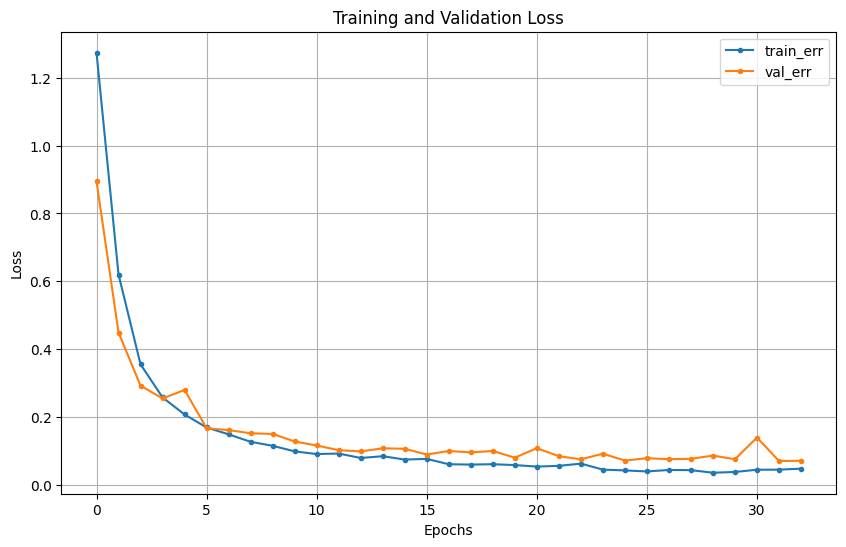

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5번째 모델
정확도: 0.9813084112149533
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 198  11   0   0   0]
 [  0   4 214   0   0   0]
 [  0   0   0 186   2   1]
 [  0   0   0   0 149   1]
 [  0   0   0   1   2 183]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.98      0.95      0.96       209
           2       0.95      0.98      0.97       218
           3       0.99      0.98      0.99       189
           4       0.97      0.99      0.98       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [46]:
model_name = "second_model"
lr = 0.0001
epochs = 100
loop_fun(model_name, model2, lr, epochs, 5, x_train, x_val, y_train, y_val)

### (3) 모델3

In [76]:
# 3번째 모델
model3 = Sequential( [Input(shape = (nfeatures,)),
                    Dense(512, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(256, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(128, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(64, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(32, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense( 6, activation = 'softmax')] )

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,502 (1.76 MB)

 Trainable params: 462,502 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

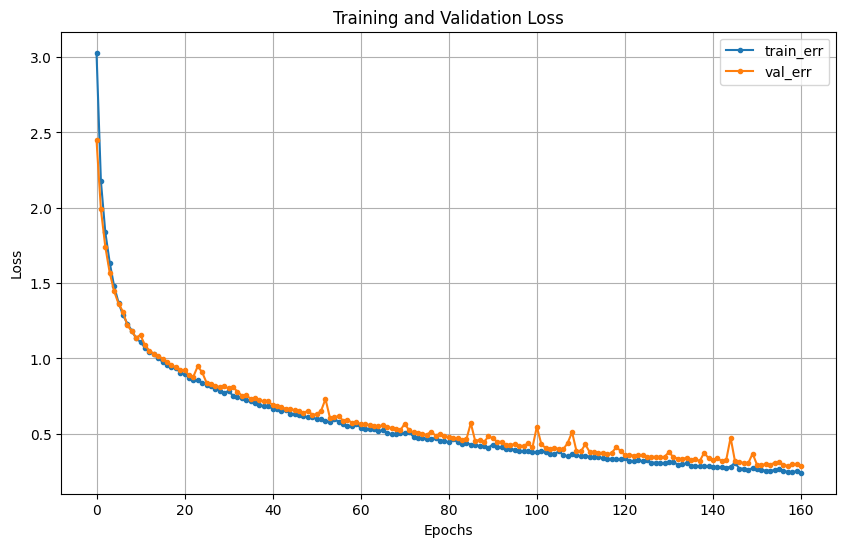

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1번째 모델
정확도: 0.9889549702633815
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 206   3   0   0   0]
 [  0   8 210   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   0   0 186]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.96      0.99      0.97       209
           2       0.99      0.96      0.97       218
           3       1.00      0.99      0.99       189
           4       0.99      1.00      1.00       150
           5       0.99      1.00      1.00       186

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


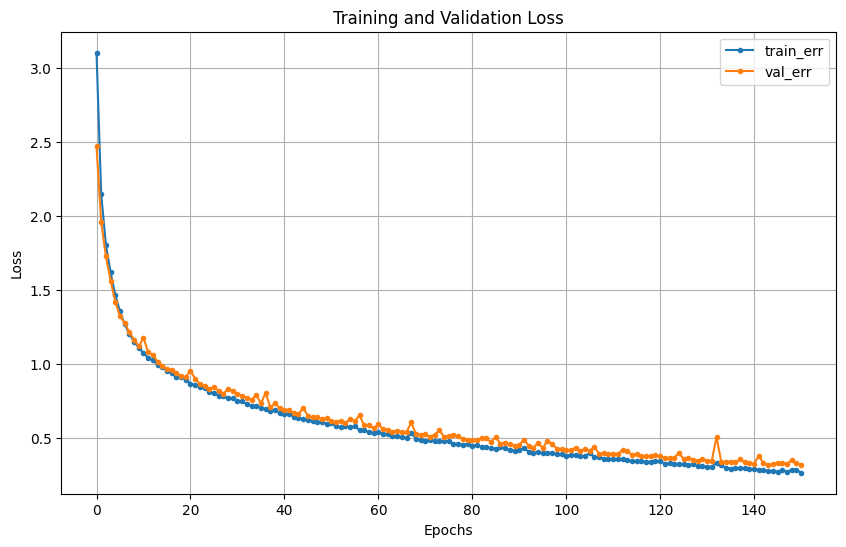

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
2번째 모델
정확도: 0.9821580288870009
혼돈 행렬
 [[225   0   0   0   0   0]
 [  1 206   2   0   0   0]
 [  0  15 203   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   1   0 185]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.93      0.99      0.96       209
           2       0.99      0.93      0.96       218
           3       0.99      0.99      0.99       189
           4       0.99      1.00      1.00       150
           5       0.99      0.99      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


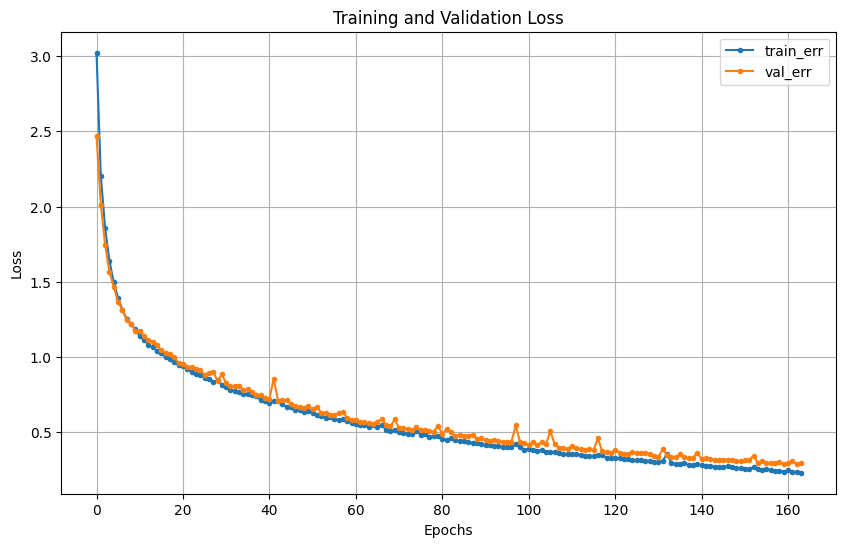

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3번째 모델
정확도: 0.9830076465590484
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 208   1   0   0   0]
 [  0  15 203   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   1 148   1]
 [  0   0   0   1   0 185]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.93      1.00      0.96       209
           2       1.00      0.93      0.96       218
           3       0.99      0.99      0.99       189
           4       1.00      0.99      0.99       150
           5       0.99      0.99      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


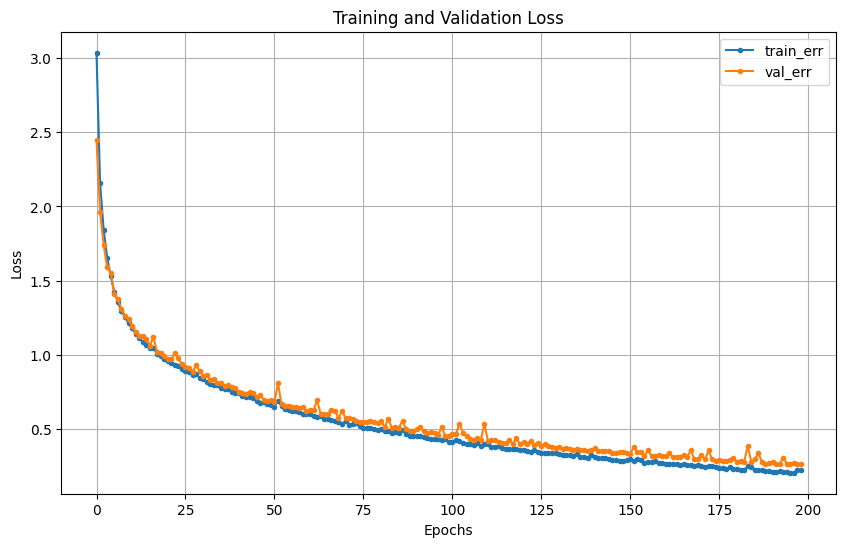

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4번째 모델
정확도: 0.983857264231096
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 198  11   0   0   0]
 [  0   3 215   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.99      0.95      0.97       209
           2       0.95      0.99      0.97       218
           3       0.99      0.99      0.99       189
           4       0.99      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


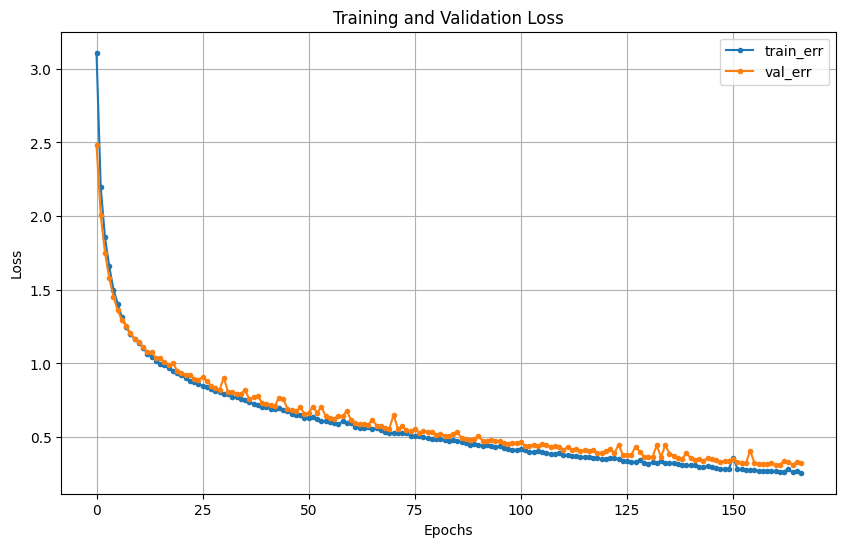

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5번째 모델
정확도: 0.9770603228547153
혼돈 행렬
 [[225   0   0   0   0   0]
 [  1 206   2   0   0   0]
 [  0  12 206   0   0   0]
 [  0   0   0 184   4   1]
 [  0   0   0   0 150   0]
 [  0   0   0   1   6 179]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.94      0.99      0.96       209
           2       0.99      0.94      0.97       218
           3       0.99      0.97      0.98       189
           4       0.94      1.00      0.97       150
           5       0.99      0.96      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [77]:
model_name = "third_model"
lr = 0.0001
epochs = 200
loop_fun(model_name, model3, lr, epochs, 5, x_train, x_val, y_train, y_val)

### (4) 모델4

In [73]:
# 4번째 모델
model4 = Sequential( [Input(shape = (nfeatures,)),
                    Dense(512, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dropout(0.3),
                    Dense(512, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dropout(0.3),
                    Dense(256, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dropout(0.3),
                    Dense(128, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dropout(0.3),
                    Dense(64, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dense(32, activation='relu',
                            kernel_regularizer = l2(0.0001)),
                    Dense( 6, activation = 'softmax')] )

model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,158 (2.77 MB)

 Trainable params: 725,158 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

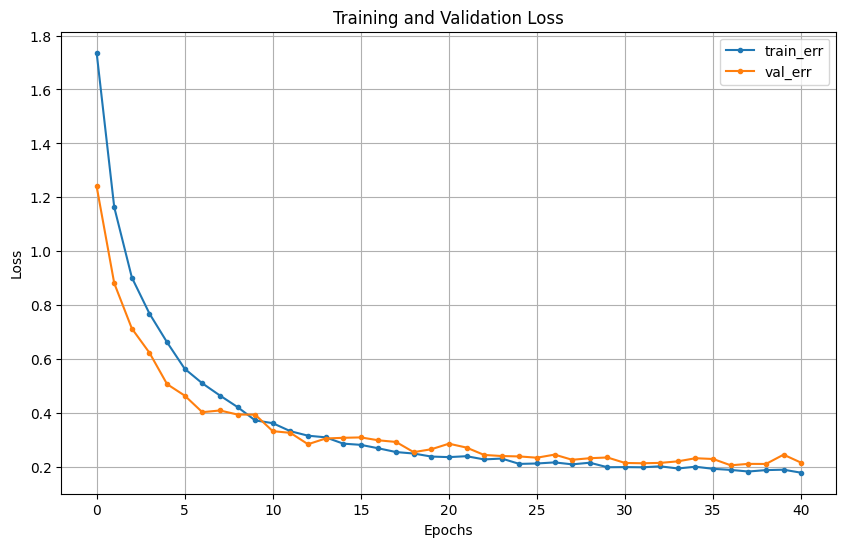

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1번째 모델
정확도: 0.9779099405267629
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 199  10   0   0   0]
 [  0   7 211   0   0   0]
 [  0   0   0 186   2   1]
 [  0   0   0   0 150   0]
 [  0   0   0   1   5 180]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.97      0.95      0.96       209
           2       0.95      0.97      0.96       218
           3       0.99      0.98      0.99       189
           4       0.96      1.00      0.98       150
           5       0.99      0.97      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


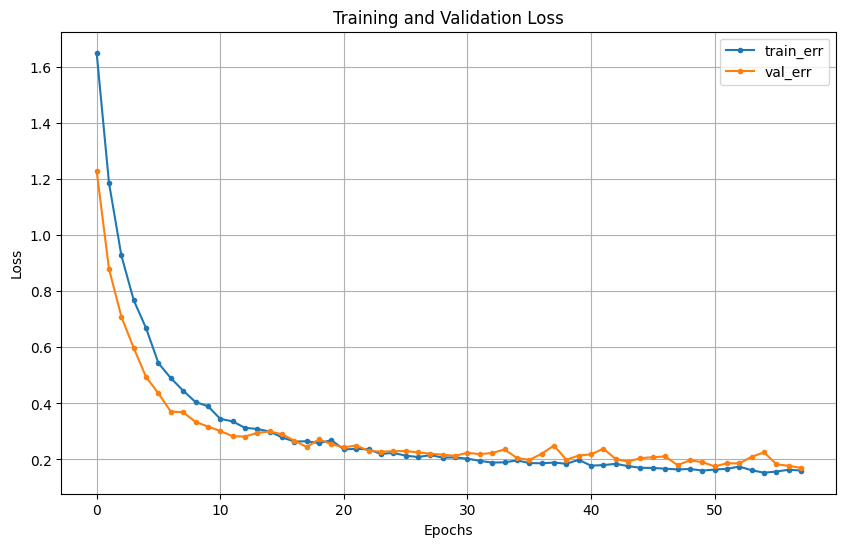

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
2번째 모델
정확도: 0.983857264231096
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 206   3   0   0   0]
 [  0  11 207   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   2 182]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.95      0.99      0.97       209
           2       0.99      0.95      0.97       218
           3       0.99      0.99      0.99       189
           4       0.99      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


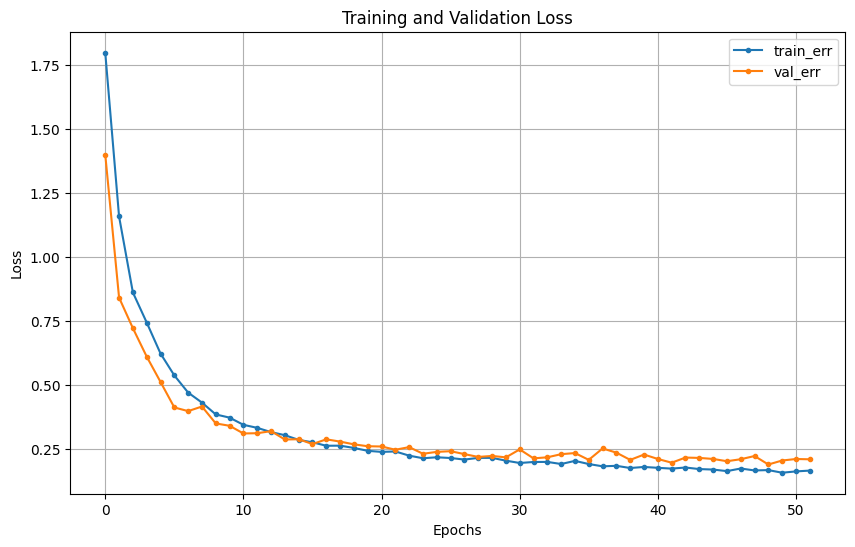

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
3번째 모델
정확도: 0.9830076465590484
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 199  10   0   0   0]
 [  0   5 213   0   0   0]
 [  0   0   0 188   0   1]
 [  0   0   0   0 148   2]
 [  0   0   0   2   0 184]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.98      0.95      0.96       209
           2       0.96      0.98      0.97       218
           3       0.99      0.99      0.99       189
           4       1.00      0.99      0.99       150
           5       0.98      0.99      0.99       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


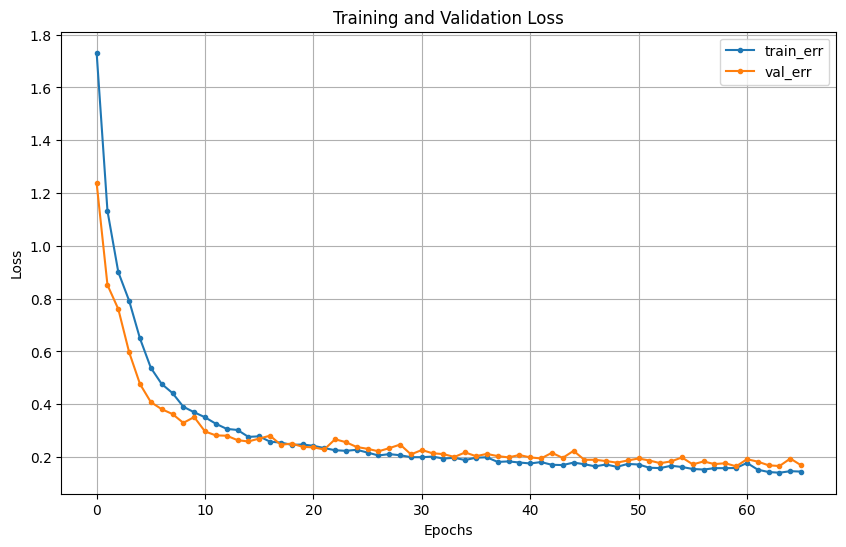

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4번째 모델
정확도: 0.9855564995751912
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 203   6   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   1   2 183]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.97      0.97      0.97       209
           2       0.97      0.97      0.97       218
           3       0.99      0.99      0.99       189
           4       0.98      1.00      0.99       150
           5       0.99      0.98      0.99       186

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


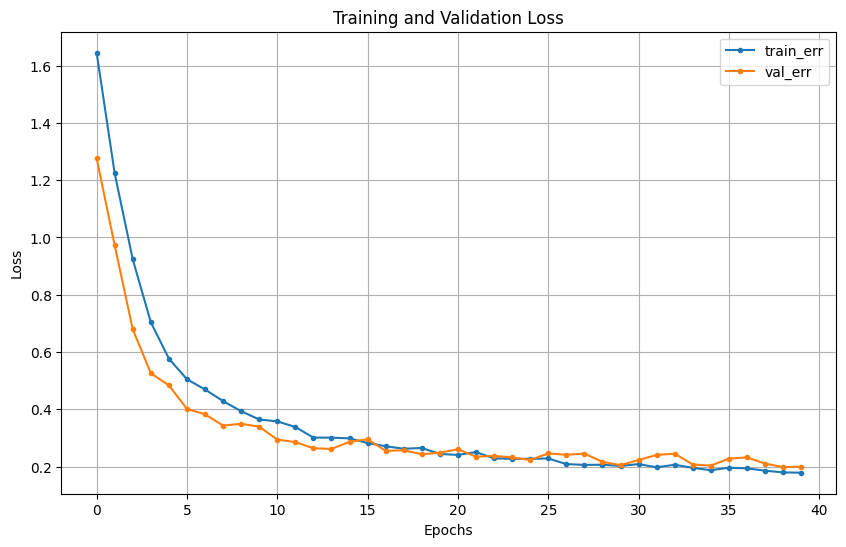

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5번째 모델
정확도: 0.9770603228547153
혼돈 행렬
 [[225   0   0   0   0   0]
 [  0 204   5   0   0   0]
 [  0  15 203   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 150   0]
 [  0   0   0   2   3 181]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.93      0.98      0.95       209
           2       0.98      0.93      0.95       218
           3       0.99      0.99      0.99       189
           4       0.97      1.00      0.99       150
           5       0.99      0.97      0.98       186

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [74]:
model_name = "fourth_model"
lr = 0.0001
epochs = 200
loop_fun(model_name, model4, lr, epochs, 5, x_train, x_val, y_train, y_val)

### (5) 모델5

In [78]:
# 중요 데이터 불러오기

data_import_att = pd.read_csv(path + 'import_att.csv')

In [120]:
# 데이터 전처리

feats_csv = pd.read_csv(path + 'features.csv')

# Feature name 분리
sensor_acc = list(set([feat for feat in feats_csv['sensor'] if 'Acc' in feat]))
sensor_gyro = list(set([feat for feat in feats_csv['sensor'] if 'Gyro' in feat]))
feats_acc = list(feats_csv.loc[feats_csv['sensor'].isin(sensor_acc)]['feature_name'])
feats_gyro = list(feats_csv.loc[feats_csv['sensor'].isin(sensor_gyro)]['feature_name'])
feats_angle = list(feats_csv.loc[feats_csv['sensor'] == 'angle']['feature_name'])

# 데이터 분할
x_tr_acc = x_train.loc[:, feats_acc].reset_index(drop=True)
x_tr_gyro = x_train.loc[:, feats_gyro].reset_index(drop=True)
x_tr_angle = x_train.loc[:, feats_angle].reset_index(drop=True)
x_val_acc = x_val.loc[:, feats_acc].reset_index(drop=True)
x_val_gyro = x_val.loc[:, feats_gyro].reset_index(drop=True)
x_val_angle = x_val.loc[:, feats_angle].reset_index(drop=True)

In [121]:
# 함수 작동 확인
print('기존 코드 결과')
print(len(x_tr_acc), len(x_tr_gyro), len(x_tr_angle), len(x_val_acc), len(x_val_gyro), len(x_val_angle))

xta, xtg, xtan, xva, xvg, xvan, ytr, yv = prep_data_fa(x, y, topn=None, path='/content/drive/MyDrive/project3/')
print('함수화 결과')
print(len(xta), len(xtg), len(xtan), len(xva), len(xvg), len(xvan))
del xta, xtg, xtan, xva, xvg, xvan, ytr, yv

기존 코드 결과
4704 4704 4704 1177 1177 1177
함수화 결과
4704 4704 4704 1177 1177 1177


In [122]:
# 모델링
## 입력부
il1 = Input(shape=(x_tr_acc.shape[1], ))
il2 = Input(shape=(x_tr_gyro.shape[1], ))
il3 = Input(shape=(x_tr_angle.shape[1], ))

## Hidden layer 1
x1 = Dense(512, activation='relu')(il1)
x2 = Dense(512, activation='relu')(il2)
x3 = Dense(512, activation='relu')(il2)

## Hidden layer 2
x1 = Dense(256, activation='relu')(x1)
x2 = Dense(256, activation='relu')(x2)
x3 = Dense(256, activation='relu')(x3)

## Hidden layer 3
x1 = Dense(128, activation='relu')(x1)
x2 = Dense(128, activation='relu')(x2)
x3 = Dense(128, activation='relu')(x3)

## Hidden layer 4
z = Concatenate()([x1, x2, x3])
z = Dense(64, activation='relu')(z)

## Hidden layer 5
z = Dense(64, activation='relu')(z)
ol = Dense(6, activation='softmax')(z)

model_fa_sensor = Model(inputs=[il1, il2, il3], outputs=ol)
model_fa_sensor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 343)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 211)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        176,128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        108,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        108,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        131,328 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │        131,328 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         32,896 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         32,896 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0],         │
│                           │                        │                │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │         24,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          4,160 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 6)              │            390 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 915,078 (3.49 MB)

 Trainable params: 915,078 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

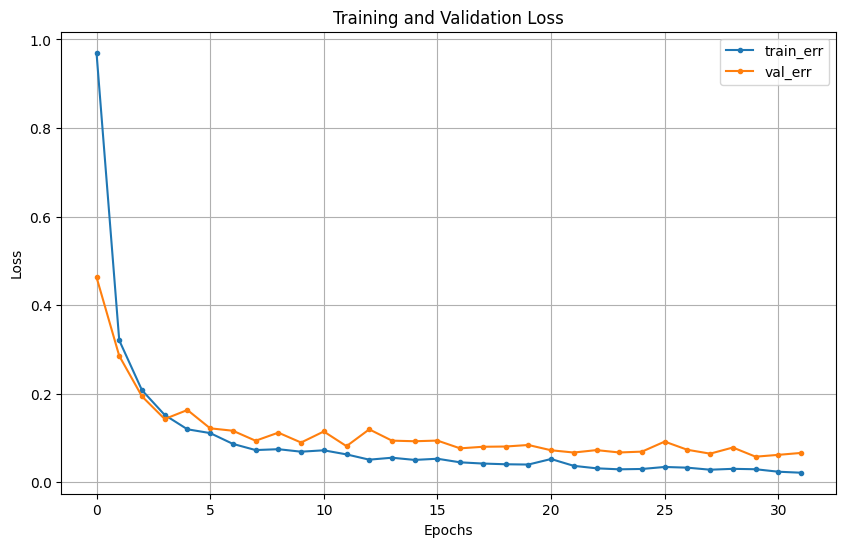

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1번째 모델
정확도: 0.9830076465590484
혼돈 행렬
 [[198  11   0   0   0   0]
 [  7 211   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   1 185   0]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       209
           1       0.95      0.97      0.96       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.99      0.99       186
           5       1.00      1.00      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


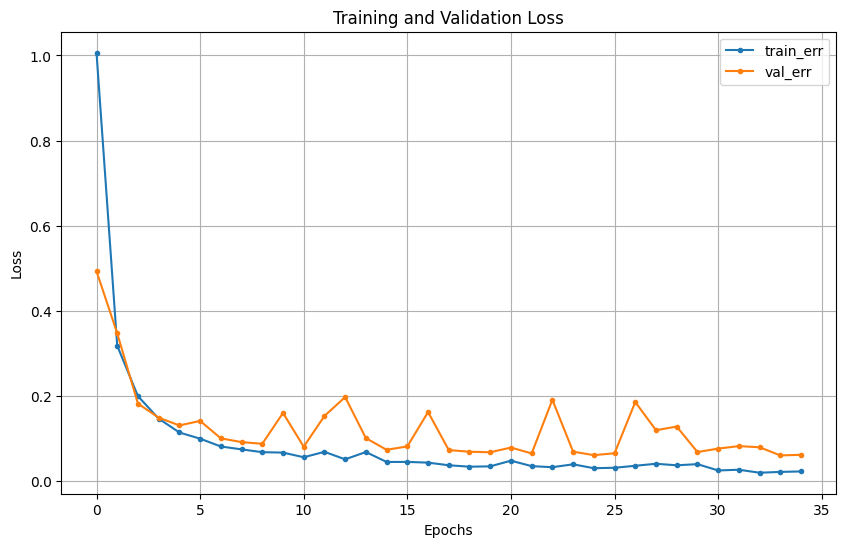

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
2번째 모델
정확도: 0.9813084112149533
혼돈 행렬
 [[202   7   0   0   0   0]
 [ 11 207   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   1 183   2]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       209
           1       0.97      0.95      0.96       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.98      0.99       186
           5       0.99      1.00      0.99       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


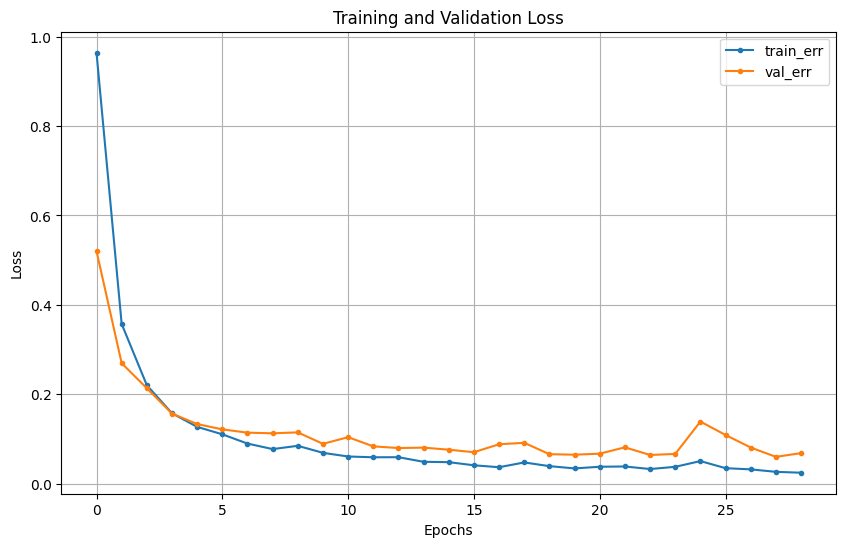

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
3번째 모델
정확도: 0.9830076465590484
혼돈 행렬
 [[198  11   0   0   0   0]
 [  6 212   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   1 184   1]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       209
           1       0.95      0.97      0.96       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.99      0.99       186
           5       0.99      1.00      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


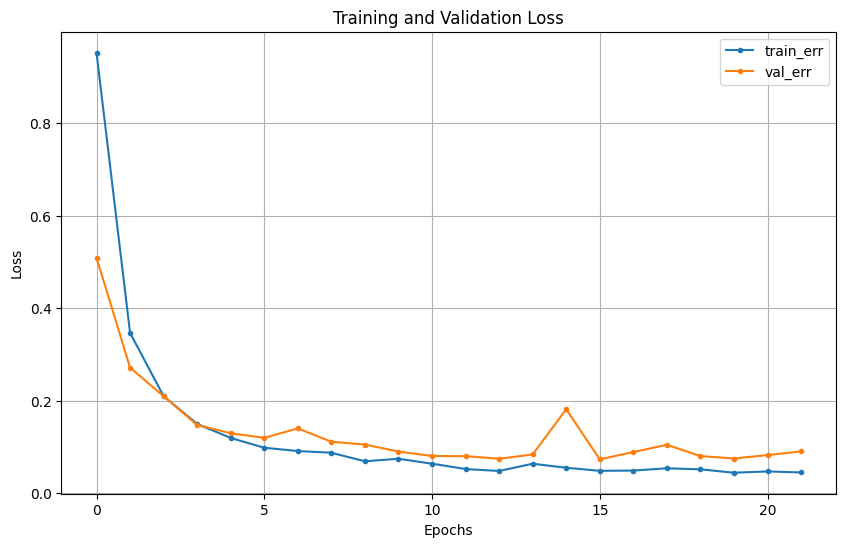

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
4번째 모델
정확도: 0.9728122344944775
혼돈 행렬
 [[184  25   0   0   0   0]
 [  3 215   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   2 183   1]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.98      0.88      0.93       209
           1       0.90      0.99      0.94       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.98      0.99       186
           5       0.99      1.00      1.00       150

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


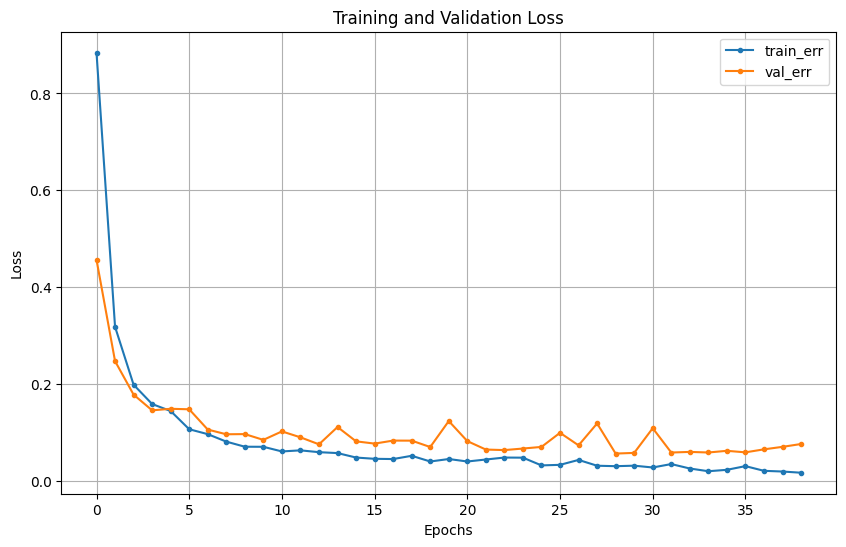

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
5번째 모델
정확도: 0.9804587935429057
혼돈 행렬
 [[207   2   0   0   0   0]
 [ 19 199   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   1 185   0]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       209
           1       0.99      0.91      0.95       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.99      0.99       186
           5       1.00      1.00      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [123]:
model_name = "fifth_model"
lr = 0.0001
epochs = 200

loop_fun(model_name, model_fa_sensor, lr, epochs, 5, [x_tr_acc, x_tr_gyro, x_tr_angle], [x_val_acc, x_val_gyro, x_val_angle], y_train, y_val)

### (6) 모델6

In [124]:
top_150_features = data_import_att['feature_name'].head(150)
x_top_150 = x.loc[:, top_150_features]

In [125]:
x_train_test, x_val_test, y_train_test, y_val_test = train_test_split(x_top_150, y, test_size=.2, random_state=1004)

In [127]:
nfeatures_test = x_train_test.shape[1]
nfeatures_test

150

In [131]:
# 3번째 모델
model6 = Sequential( [Input(shape = (nfeatures_test,)),
                    Dense(512, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(256, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(128, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(64, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense(32, activation='relu',
                            kernel_regularizer = l1(0.0001)),
                    Dense( 6, activation = 'softmax')] )

model6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │          77,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,070 (984.65 KB)

 Trainable params: 252,070 (984.65 KB)

 Non-trainable params: 0 (0.00 B)

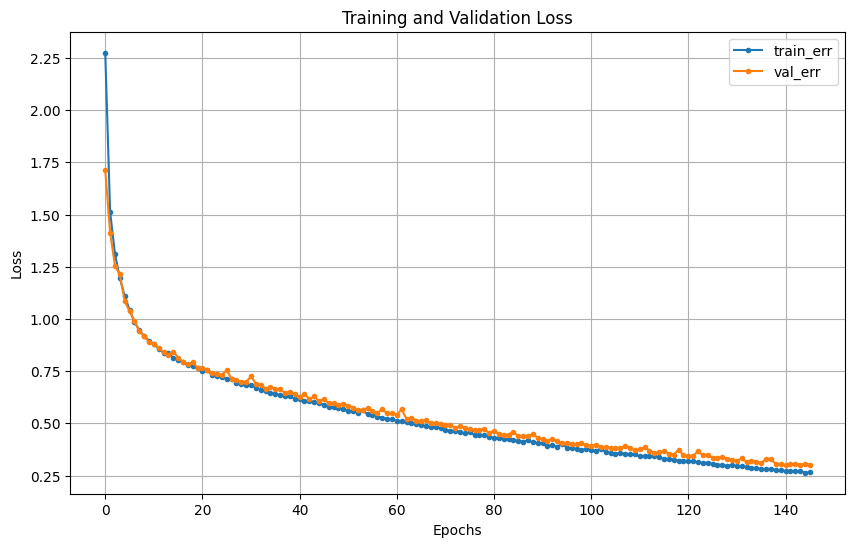

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1번째 모델
정확도: 0.9770603228547153
혼돈 행렬
 [[205   4   0   0   0   0]
 [ 21 197   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 189   0   0]
 [  0   0   0   2 184   0]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       209
           1       0.98      0.90      0.94       218
           2       1.00      1.00      1.00       225
           3       0.99      1.00      0.99       189
           4       1.00      0.99      0.99       186
           5       1.00      1.00      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


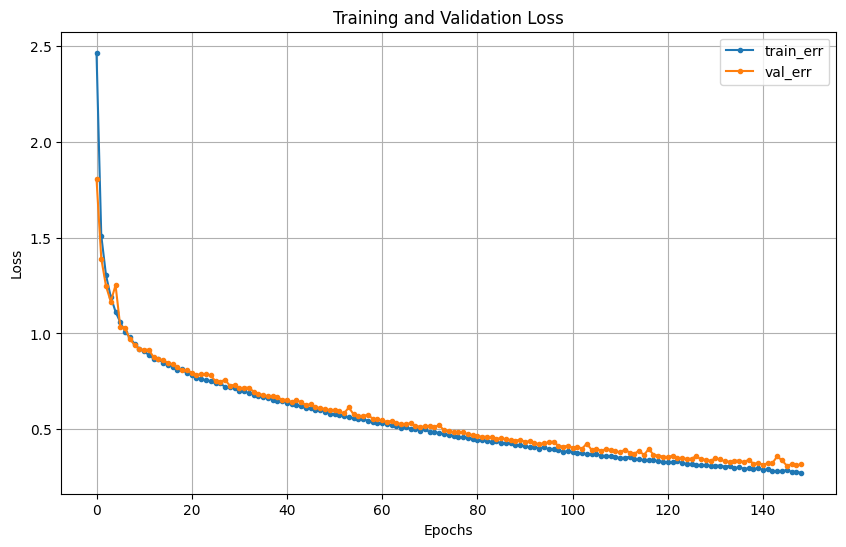

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2번째 모델
정확도: 0.9745114698385726
혼돈 행렬
 [[206   3   0   0   0   0]
 [ 24 194   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 189   0   0]
 [  0   0   0   2 183   1]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       209
           1       0.98      0.89      0.93       218
           2       1.00      1.00      1.00       225
           3       0.99      1.00      0.99       189
           4       1.00      0.98      0.99       186
           5       0.99      1.00      1.00       150

    accuracy                           0.97      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.97      0.97      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


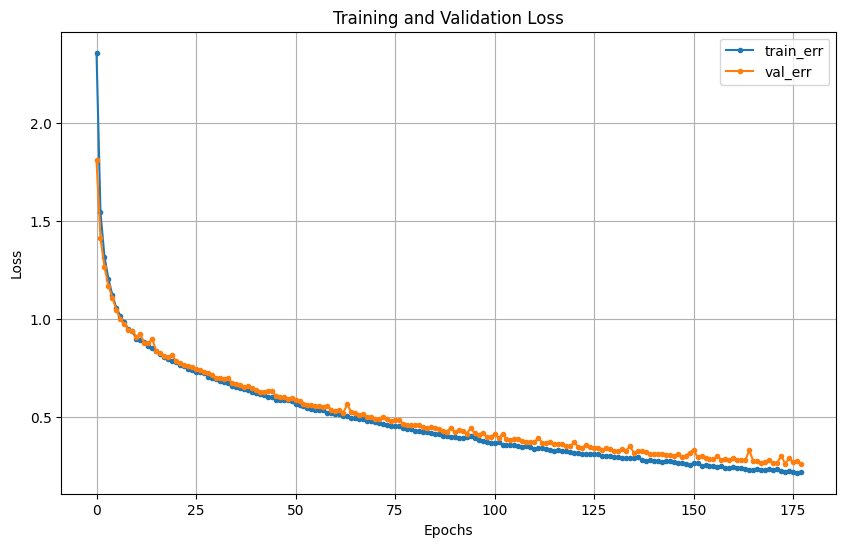

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3번째 모델
정확도: 0.9796091758708582
혼돈 행렬
 [[198  11   0   0   0   0]
 [  9 209   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 188   1   0]
 [  0   0   0   2 184   0]
 [  0   0   0   0   1 149]]
분류 보고서
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       209
           1       0.95      0.96      0.95       218
           2       1.00      1.00      1.00       225
           3       0.99      0.99      0.99       189
           4       0.99      0.99      0.99       186
           5       1.00      0.99      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


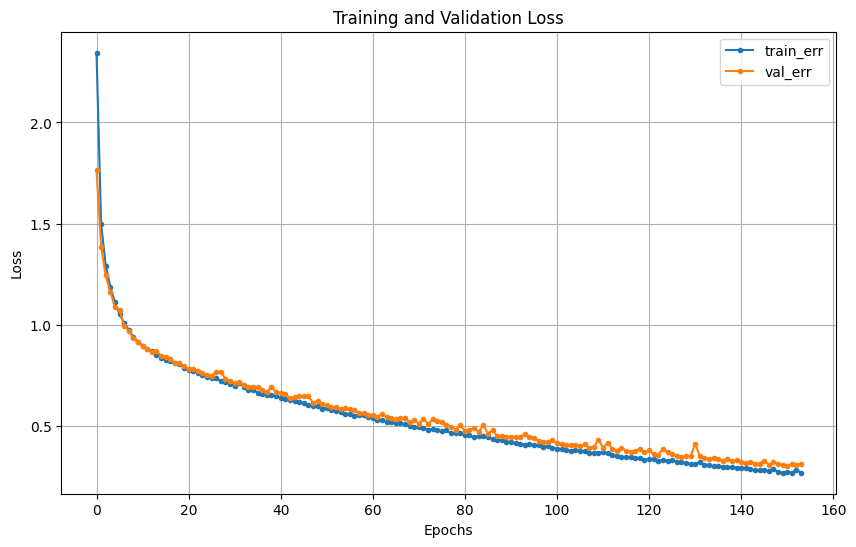

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4번째 모델
정확도: 0.9762107051826678
혼돈 행렬
 [[188  21   0   0   0   0]
 [  4 214   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 189   0   0]
 [  0   0   0   2 184   0]
 [  0   0   0   0   1 149]]
분류 보고서
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       209
           1       0.91      0.98      0.94       218
           2       1.00      1.00      1.00       225
           3       0.99      1.00      0.99       189
           4       0.99      0.99      0.99       186
           5       1.00      0.99      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 


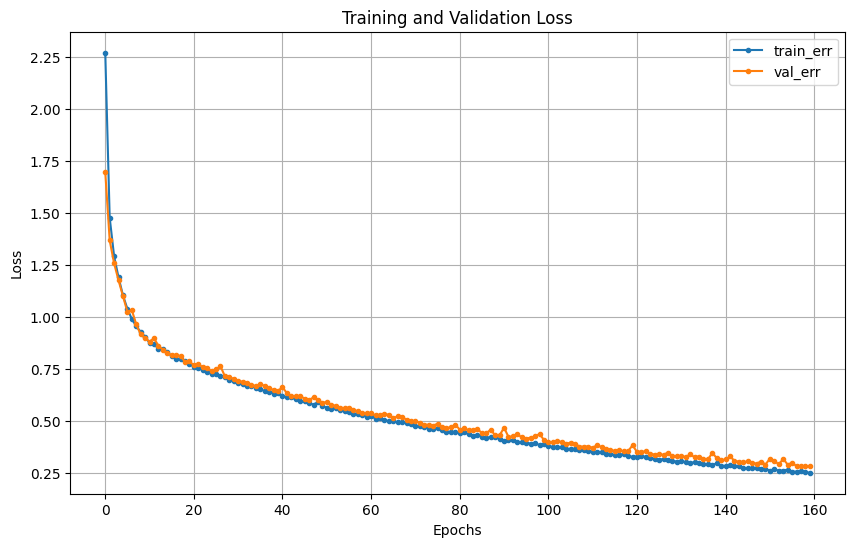

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5번째 모델
정확도: 0.9821580288870009
혼돈 행렬
 [[197  12   0   0   0   0]
 [  6 212   0   0   0   0]
 [  0   0 225   0   0   0]
 [  0   0   0 189   0   0]
 [  0   0   0   2 183   1]
 [  0   0   0   0   0 150]]
분류 보고서
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       209
           1       0.95      0.97      0.96       218
           2       1.00      1.00      1.00       225
           3       0.99      1.00      0.99       189
           4       1.00      0.98      0.99       186
           5       0.99      1.00      1.00       150

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 

In [132]:
model_name = "sixth_model"
lr = 0.0001
epochs = 200
loop_fun(model_name, model6, lr, epochs, 5, x_train_test, x_val_test, y_train_test, y_val_test)

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [156]:
x_test = data_test.drop(target, axis = 1)
y_test = data_test.loc[:, [target]]

In [157]:
# x_test = scaler.fit_transform(x_test)

scaler = MinMaxScaler()

df = scaler.fit_transform(x_test)

x_test = pd.DataFrame(df, columns=x_test.columns)

In [158]:
int_Encoder = LabelEncoder()
y_test = int_Encoder.fit_transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [162]:
test_model = load_model(path + 'sixth.keras')

ValueError: File not found: filepath=/content/drive/MyDrive/project3/sixth.keras. Please ensure the file is an accessible `.keras` zip file.

In [161]:
# x_test_150 = x_test.loc[:, top_150_features]

# pred = test_model.predict(x_test_150)

pred = test_model.predict(x_test)
pred_result = pred.argmax(axis=1)
confusion = confusion_matrix(y_test, pred_result)
report = classification_report(y_test, pred_result)
accuracy = accuracy_score(y_test, pred_result)

print(f"정확도: {accuracy}")
print(f"혼돈 행렬\n {confusion}")
print(f"분류 보고서\n {report}")
print("- * " * 30)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
정확도: 0.9619306594153637
혼돈 행렬
 [[290   0   0   0   2   0]
 [  0 217  37   0   0   0]
 [  0   4 282   0   0   1]
 [  0   0   0 228   0   0]
 [  0   0   0   1 194   0]
 [  0   0   0  10   1 204]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.98      0.85      0.91       254
           2       0.88      0.98      0.93       287
           3       0.95      1.00      0.98       228
           4       0.98      0.99      0.99       195
           5       1.00      0.95      0.97       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
